# Object Detection with GluonCV

This tutorial focus on illustrating the APIs GluonCV provided for object detection tasks.


In [2]:
# !pip install mxnet-cu100mkl
# !pip install gluoncv --pre

In [3]:
import time
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon, nd, image
from mxnet.gluon.data.vision import transforms

import gluoncv
from gluoncv.utils import download, viz
from gluoncv.model_zoo import get_model
from gluoncv.utils import viz, download

## Try Object Detection with GluonCV pretrained models

Next, let's try to use object detection to detect the multiple objects.

Firstly we again load the image in and preprocess it at the same time. Here the `short=512` means we resize the short edge to 512 pixels while keeping the aspect ratio.

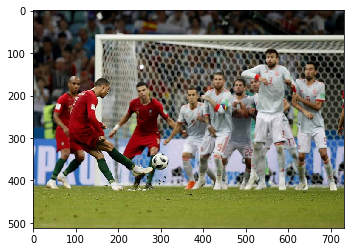

In [4]:
x, img = gluoncv.data.transforms.presets.ssd.load_test('cr7.jpg', short=512)
viz.plot_image(img)
plt.show()

Next, we download a pretraiend SSD. Here `yolo3_mobilenet1.0_coco` is a combination of:

1. `yolo3`: the algorithm of the model
2. `mobilenet1.0`: the base model
3. `coco`: the dataset on which the model is trained

Again, you can check the available models in this page:

https://gluon-cv.mxnet.io/model_zoo/detection.html

In [5]:
net = get_model('yolo3_mobilenet1.0_coco', pretrained=True)

The output contains the predicted classes, the confident scores and the location of bounding boxes.

With `gluoncv.utils.viz` we can easily visualize the result.


Prediction time:  0.047698974609375


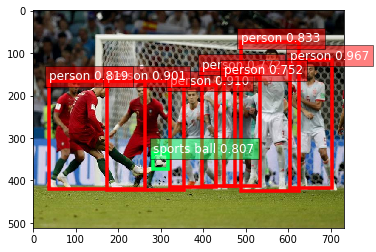

In [6]:
tic = time.time()
class_IDs, scores, bounding_boxs = net(x)
print('Prediction time: ', time.time() - tic)
viz.plot_bbox(img, bounding_boxs[0], scores[0], class_IDs[0], class_names=net.classes)
plt.show()

### Customize pretrained models

In many real world scenarios, we usually want to detect a special set of objects. However, training/fine-tuning a models is not free, given a model that can detect multiple categories, we can always customize the models.

There are basically two ways to do so with a pretrained model, e.g., a model trained on COCO dataset:

- Post process the detected objects, remove unwanted categories
- Modify the detection network to predict a subset of categories it can detect

GluonCV prefers the latter approach because it can:

- Reduce network computation: output channels reduced to N rather than 80 (Minor speed up).
- Reduce NMS workload: perform NMS over e.g. 10 objects rather than 100 (speed up can be significant sometimes).

Prediction time:  0.02557516098022461


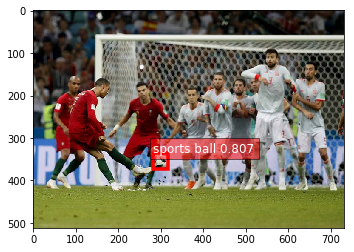

In [7]:
net.reset_class(['sports ball'], reuse_weights={'sports ball': 'sports ball'})
tic = time.time()
class_IDs, scores, bounding_boxs = net(x)
print('Prediction time: ', time.time() - tic)
viz.plot_bbox(img, bounding_boxs[0], scores[0], class_IDs[0], class_names=net.classes)
plt.show()

## Train your own model to detect Pikachu

Pre-trained models only recognize the type of objects in the dataset. What if you have your own object of interests and want to train a model for that?

No problem! We'll show an example of teaching a pre-trained model to recognize Pikachu.

First we download the small dataset.

In [8]:
url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/train.rec'
idx_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/train.idx'
download(url, path='pikachu_train.rec', overwrite=False)
download(idx_url, path='pikachu_train.idx', overwrite=False)

85605KB [00:10, 8378.50KB/s]                           
12KB [00:00, 1597.42KB/s]             

'pikachu_train.idx'

Next we load in the dataset and show how it looks like.

label: [[214.70685 132.91504 271.07706 215.32448   0.     ]]


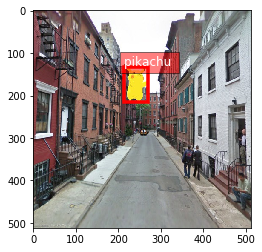

In [9]:
dataset = gluoncv.data.RecordFileDetection('pikachu_train.rec')
classes = ['pikachu']  # only one foreground class here
image, label = dataset[1]
print('label:', label)
# display image and label
ax = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5], class_names=classes)
plt.show()

Basically we chose some landscape photos and copy an open-sourced Pikachu figure onto the image.

We load in a pretrained `ssd_512_mobilenet1.0_voc` model and reset its output layer.

In [10]:
net = gluoncv.model_zoo.get_model('ssd_512_mobilenet1.0_voc', pretrained=True)
net.reset_class(classes)
net = gluoncv.model_zoo.get_model('ssd_512_mobilenet1.0_custom', classes=classes,
    pretrained_base=False, transfer='voc')

/Users/zhiz/Dev/mxnet/python/mxnet/gluon/block.py:1328: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


Next we define the dataloader.

In [11]:
def get_dataloader(net, train_dataset, data_shape, batch_size, num_workers):
    from gluoncv.data.batchify import Tuple, Stack, Pad
    from gluoncv.data.transforms.presets.ssd import SSDDefaultTrainTransform
    width, height = data_shape, data_shape
    # use fake data to generate fixed anchors for target generation
    with autograd.train_mode():
        _, _, anchors = net(mx.nd.zeros((1, 3, height, width)))
    batchify_fn = Tuple(Stack(), Stack(), Stack())  # stack image, cls_targets, box_targets
    train_loader = gluon.data.DataLoader(
        train_dataset.transform(SSDDefaultTrainTransform(width, height, anchors)),
        batch_size, True, batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)
    return train_loader

train_data = get_dataloader(net, dataset, 512, 16, 0)

We encourage to use GPU for the training.

In [12]:
ctx = [mx.gpu(0)]
net.collect_params().reset_ctx(ctx)

MXNetError: [15:25:52] src/ndarray/ndarray.cc:1295: GPU is not enabled
Stack trace:
  [bt] (0) 1   libmxnet.so                         0x0000000113bd08b9 dmlc::LogMessageFatal::~LogMessageFatal() + 57
  [bt] (1) 2   libmxnet.so                         0x0000000115b1e1b9 mxnet::CopyFromTo(mxnet::NDArray const&, mxnet::NDArray const&, int, bool) + 4057
  [bt] (2) 3   libmxnet.so                         0x0000000115a5bd2c mxnet::imperative::PushFComputeEx(std::__1::function<void (nnvm::NodeAttrs const&, mxnet::OpContext const&, std::__1::vector<mxnet::NDArray, std::__1::allocator<mxnet::NDArray> > const&, std::__1::vector<mxnet::OpReqType, std::__1::allocator<mxnet::OpReqType> > const&, std::__1::vector<mxnet::NDArray, std::__1::allocator<mxnet::NDArray> > const&)> const&, nnvm::Op const*, nnvm::NodeAttrs const&, mxnet::Context const&, std::__1::vector<mxnet::engine::Var*, std::__1::allocator<mxnet::engine::Var*> > const&, std::__1::vector<mxnet::engine::Var*, std::__1::allocator<mxnet::engine::Var*> > const&, std::__1::vector<mxnet::Resource, std::__1::allocator<mxnet::Resource> > const&, std::__1::vector<mxnet::NDArray*, std::__1::allocator<mxnet::NDArray*> > const&, std::__1::vector<mxnet::NDArray*, std::__1::allocator<mxnet::NDArray*> > const&, std::__1::vector<mxnet::OpReqType, std::__1::allocator<mxnet::OpReqType> > const&)::'lambda'(mxnet::RunContext)::operator()(mxnet::RunContext) const + 204
  [bt] (3) 4   libmxnet.so                         0x0000000115a4acbe mxnet::imperative::PushFComputeEx(std::__1::function<void (nnvm::NodeAttrs const&, mxnet::OpContext const&, std::__1::vector<mxnet::NDArray, std::__1::allocator<mxnet::NDArray> > const&, std::__1::vector<mxnet::OpReqType, std::__1::allocator<mxnet::OpReqType> > const&, std::__1::vector<mxnet::NDArray, std::__1::allocator<mxnet::NDArray> > const&)> const&, nnvm::Op const*, nnvm::NodeAttrs const&, mxnet::Context const&, std::__1::vector<mxnet::engine::Var*, std::__1::allocator<mxnet::engine::Var*> > const&, std::__1::vector<mxnet::engine::Var*, std::__1::allocator<mxnet::engine::Var*> > const&, std::__1::vector<mxnet::Resource, std::__1::allocator<mxnet::Resource> > const&, std::__1::vector<mxnet::NDArray*, std::__1::allocator<mxnet::NDArray*> > const&, std::__1::vector<mxnet::NDArray*, std::__1::allocator<mxnet::NDArray*> > const&, std::__1::vector<mxnet::OpReqType, std::__1::allocator<mxnet::OpReqType> > const&) + 1086
  [bt] (4) 5   libmxnet.so                         0x0000000115a4921a mxnet::Imperative::InvokeOp(mxnet::Context const&, nnvm::NodeAttrs const&, std::__1::vector<mxnet::NDArray*, std::__1::allocator<mxnet::NDArray*> > const&, std::__1::vector<mxnet::NDArray*, std::__1::allocator<mxnet::NDArray*> > const&, std::__1::vector<mxnet::OpReqType, std::__1::allocator<mxnet::OpReqType> > const&, mxnet::DispatchMode, mxnet::OpStatePtr) + 570
  [bt] (5) 6   libmxnet.so                         0x0000000115a4da32 mxnet::Imperative::Invoke(mxnet::Context const&, nnvm::NodeAttrs const&, std::__1::vector<mxnet::NDArray*, std::__1::allocator<mxnet::NDArray*> > const&, std::__1::vector<mxnet::NDArray*, std::__1::allocator<mxnet::NDArray*> > const&) + 578
  [bt] (6) 7   libmxnet.so                         0x00000001159718db MXImperativeInvokeImpl(void*, int, void**, int*, void***, int, char const**, char const**) + 315
  [bt] (7) 8   libmxnet.so                         0x0000000115972b5b MXImperativeInvokeEx + 107
  [bt] (8) 9   _ctypes.cpython-37m-darwin.so       0x000000010b3c936f ffi_call_unix64 + 79



Next we define the trainer, loss and metric.

In [ ]:
trainer = gluon.Trainer(
    net.collect_params(), 'sgd',
    {'learning_rate': 0.001, 'wd': 0.0005, 'momentum': 0.9})
mbox_loss = gluoncv.loss.SSDMultiBoxLoss()
ce_metric = mx.metric.Loss('CrossEntropy')
smoothl1_metric = mx.metric.Loss('SmoothL1')

Everything's prepared. We can start training now. We just need 2 epochs for this dataset.

In [ ]:
for epoch in range(0, 2):
    ce_metric.reset()
    smoothl1_metric.reset()
    tic = time.time()
    btic = time.time()
    net.hybridize(static_alloc=True, static_shape=True)
    for i, batch in enumerate(train_data):
        batch_size = batch[0].shape[0]
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        cls_targets = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        box_targets = gluon.utils.split_and_load(batch[2], ctx_list=ctx, batch_axis=0)
        with autograd.record():
            cls_preds = []
            box_preds = []
            for x in data:
                cls_pred, box_pred, _ = net(x)
                cls_preds.append(cls_pred)
                box_preds.append(box_pred)
            sum_loss, cls_loss, box_loss = mbox_loss(
                cls_preds, box_preds, cls_targets, box_targets)
            autograd.backward(sum_loss)
        # since we have already normalized the loss, we don't want to normalize
        # by batch-size anymore
        trainer.step(1)
        ce_metric.update(0, [l * batch_size for l in cls_loss])
        smoothl1_metric.update(0, [l * batch_size for l in box_loss])
        name1, loss1 = ce_metric.get()
        name2, loss2 = smoothl1_metric.get()
        if i % 10 == 0:
            print('[Epoch {}][Batch {}], Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}'.format(
                epoch, i, batch_size/(time.time()-btic), name1, loss1, name2, loss2))
        btic = time.time()

net.save_parameters('ssd_512_mobilenet1.0_pikachu.params')

Finished!

We have a test image with multiple Pikachus. Let's see if we can detect all of them.

In [ ]:
test_url = 'https://raw.githubusercontent.com/zackchase/mxnet-the-straight-dope/master/img/pikachu.jpg'
download(test_url, 'pikachu_test.jpg')
net = gluoncv.model_zoo.get_model('ssd_512_mobilenet1.0_custom', classes=classes, pretrained_base=False)
net.load_parameters('ssd_512_mobilenet1.0_pikachu.params')
x, image = gluoncv.data.transforms.presets.ssd.load_test('pikachu_test.jpg', 512)
cid, score, bbox = net(x)
ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=classes)
plt.show()